# 发现低价的机票

本文通过机器学习来获取网络上的低价机票。

## 1.使用高级网络爬虫技术检索票价数据

Google提供了一个鲜为人知的工具，被称为航班查询器。此工具可以让你查看中数月的时间内，从一个地区到另一个地区的最低票价。由于网页是基于AJAX的，因此我们要用到两个库Selenium和PhantomJS。Selenium是一个强大的工具，它可以自动化Web浏览器，而PhantomJS是一个无界面浏览器。

现在可以开始动手了，首先导入需要的各种库：

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from bs4 import BeautifulSoup

接下来，用代码实例化浏览器对象，查找从圣弗朗西斯科（旧金山）到几个中国城市的行程。

In [16]:
url = "https://www.google.com/flights/explore/#explore;f=SFO;t=PEK,PVG,HKG,XIY,CKG,CAN,SZX;s=1;li=8;lx=12;d=2018-04-03"
dcap = dict(DesiredCapabilities.PHANTOMJS)
dcap["phantomjs.page.settings.userAgent"] = ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36")
driver = webdriver.PhantomJS(desired_capabilities=dcap)
driver.implicitly_wait(20)
driver.get(url)

/Users/jing/.virtualenvs/pydata/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


运行上面的代码后，使用下面的代码保存页面的截图。

In [18]:
driver.save_screenshot(r'flight_explorer.png')

True

## 1.2解析DOM以提取定价数据

DOM是形成网页结构的元素集合，它包括例如body、div、class和id这样的元素和标签。我们要处理这些元素来提取所需的数据。
使用Chrome浏览器，在页面上单击右键，单击“检查”，打开开发人员选项卡，找到需要提取的价格标签，右键“检查”，浏览器下方的窗口会高亮显示选择的内容，找到'span'里面包裹的就是我们需要的价格，记下'span'的属性'CTPFVNB-v-k'。

接下来，将上面获取的页面源文件提交给BeautifulSoup进行解析。

In [19]:
s = BeautifulSoup(driver.page_source, "lxml")

<!DOCTYPE html>
<html lang="en-US"><head><meta content="text/html; charset=utf-8" http-equiv="content-type"/><meta content="baseUrl=/flights/explore//static/" name="deals::gwt:property"/><title>Explore flights</title><meta content="Explore flights" name="description"/><script async="" src="https://apis.google.com/_/scs/abc-static/_/js/k=gapi.gapi.en.qJZuTTuHcJE.O/m=gapi_iframes,googleapis_client,plusone/rt=j/sv=1/d=1/ed=1/am=AAE/rs=AHpOoo8glyl83aQK4S9K5v-KraVNbM7RrQ/cb=gapi.loaded_0"></script><script language="javascript" type="text/javascript">
var __JS_ILT__ = new Date();
</script>
<style type="text/css">@-webkit-keyframes gb__a{0%{opacity:0}50%{opacity:1}}@keyframes gb__a{0%{opacity:0}50%{opacity:1}}.gb_bb{display:none!important}.gb_cb{visibility:hidden}.gb_9c{display:inline-block;padding:0 0 0 15px;vertical-align:middle}.gb_9c:first-child,#gbsfw:first-child+.gb_9c{padding-left:0}.gb_Qc{position:relative}.gb_b{display:inline-block;outline:none;vertical-align:middle;-webkit-border-ra
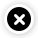
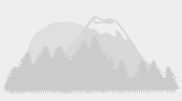

In [20]:
s

获取所有最佳价格的列表：

In [27]:
best_price_tags = s.find_all('span', 'CTPFVNB-v-k') 
best_prices = []
for tag in best_price_tags:
    best_prices.append(int(tag.text.replace('$','')))

In [28]:
best_price_tags

[<span class="CTPFVNB-v-k">$459</span>,
 <span class="CTPFVNB-v-k">$506</span>,
 <span class="CTPFVNB-v-k">$509</span>,
 <span class="CTPFVNB-v-k">$542</span>,
 <span class="CTPFVNB-v-k">$602</span>,
 <span class="CTPFVNB-v-k">$622</span>,
 <span class="CTPFVNB-v-k">$762</span>]

In [29]:
best_price = best_prices[0]
best_price

459

接下来，获取包含每个柱状条的高度的列表。

In [30]:
best_height_tags = s.find_all('div', 'CTPFVNB-w-f')
best_heights = []
for t in best_height_tags:
    best_heights.append(float(t.attrs['style']\
                              .split('height:')[1].replace('px;','')))

In [31]:
best_height = best_heights[0]
best_height

51.94567062818336

然后计算每个高度像素所对应的价格：

In [32]:
pph = np.array(best_price)/np.array(best_height)
pph

8.836155052948099

接下来，检索每个城市所有航班的价格条的高度：

In [33]:
cities = s.find_all('div', 'CTPFVNB-w-o')
cities

[<div class="CTPFVNB-w-o CTPFVNB-w-b"><div class="CTPFVNB-w-x CTPFVNB-w-f" style="left: 0px; height: 51.94567062818336px;"></div><div class="CTPFVNB-w-x" style="left: 6px; height: 55.405772495755514px;"></div><div class="CTPFVNB-w-x" style="left: 12px; height: 55.405772495755514px;"></div><div class="CTPFVNB-w-x" style="left: 18px; height: 55.405772495755514px;"></div><div class="CTPFVNB-w-x CTPFVNB-w-M" style="left: 24px; height: 57.05829088851161px;"></div><div class="CTPFVNB-w-x CTPFVNB-w-M" style="left: 30px; height: 55.405772495755514px;"></div><div class="CTPFVNB-w-x" style="left: 36px; height: 55.405772495755514px;"></div><div class="CTPFVNB-w-x" style="left: 42px; height: 55.25070741369554px;"></div><div class="CTPFVNB-w-x" style="left: 48px; height: 55.405772495755514px;"></div><div class="CTPFVNB-w-x" style="left: 54px; height: 55.405772495755514px;"></div><div class="CTPFVNB-w-x" style="left: 60px; height: 55.405772495755514px;"></div><div class="CTPFVNB-w-x CTPFVNB-w-M" sty

In [34]:
len(cities)

7

In [35]:
hlist=[]
for bar in cities[0]\
    .findAll('div', 'CTPFVNB-w-x'):
    hlist.append(float(bar['style']\
                       .split('height: ')[1].replace('px;',''))*pph)

In [36]:
fares = pd.DataFrame(hlist, columns=['price'])

任务完成来，现在获得了一个DataFrame数据，包含了两个月最便宜的票价。

In [37]:
fares.min()

price    459.0
dtype: float64

再看下完整的列表及详细信息：

In [38]:
fares

,price
0,459.000000
1,489.573997
2,489.573997
3,489.573997
4,504.175905
5,489.573997
6,489.573997
7,488.203817
8,489.573997
9,489.573997


In [39]:
fares.median()

price    496.874951
dtype: float64

In [40]:
fares.describe()

,price
count,60.000000
mean,526.168113
std,57.621992
min,459.000000
25%,489.573997
50%,496.874951
75%,537.830305
max,753.608511


## 1.3通过聚类算法识别异常低的票价

机票价格每天都在不断地更新，如果我们试图确定远低于正常的价格，不使用机器学习的技术怎么行？

聚类算法有许多种，对于这里所处理的数据类型，我们使用DBSCAN（基于密度的空间聚类算法），它适合带有噪音的数据的应用。这是一种非常有效的算法，倾向于使用和人类相同的方式来识别点的集群。

关于DBSCAN算法的工作原理这里不再细讲，现在将其应用到机票的数据上。我们首先创建一个简单的图像来检视票价。

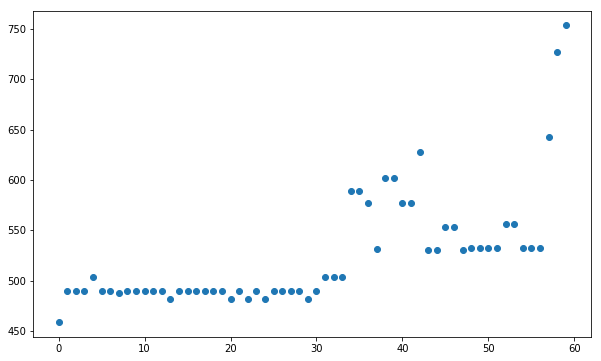

In [41]:
fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(np.arange(len(fares['price'])),fares['price'])

可以看到，票价平稳了几个星期后，然后开始急剧上升。现在编写代码来识别和显示这些集群。

首先，设置一个priceDataFrame，然后将DBSCAN对象传入其中。

In [42]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [43]:
px = [x for x in fares['price']]
ff = pd.DataFrame(px, columns=['fare']).reset_index()

下面的代码将DBSCAN算法应用于票价数据并输出一个可视化图像。

Text(0.5,1.01,'Total Clusters: 5')

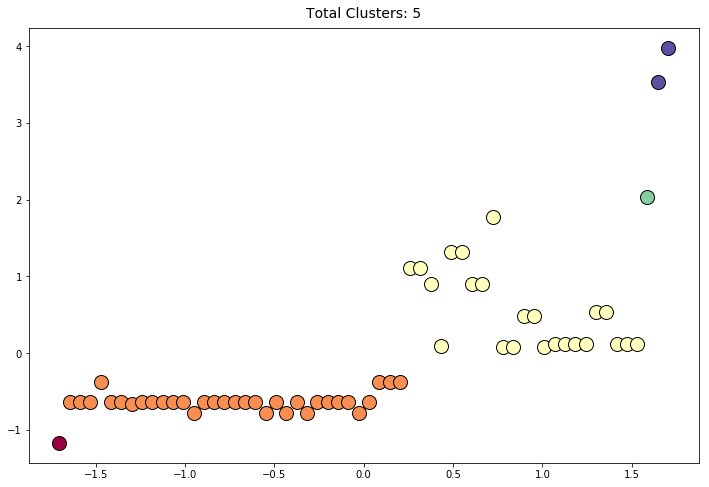

In [44]:
X = StandardScaler().fit_transform(ff)
db = DBSCAN(eps=.5, min_samples=1).fit(X)

labels = db.labels_
clusters = len(set(labels))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0,
                        1, len(unique_labels)))

plt.subplots(figsize=(12,8))

for k, c in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o',
             markerfacecolor=c,
             markeredgecolor='k',
             markersize=14)

plt.title("Total Clusters: {}".format(clusters),
          fontsize=14, y=1.01)

上面的代码中，第一行使用StandardScaler()方法，这个对象获取数据，对每个点减去平均值，然后除以标准差，这种标准化方法称为Z-Score。标准化之后的数据传给了DBSCAN对象。

算法确定了五个不同的聚类。

现在，我们要做的是修改某些票价的数据，来看看是否会有新的聚类产生。首先，创建一个函数用来方便的进行数据更改和执行聚类算法。

In [45]:
def test_clusters(data_series, eps_val, swap_index, swap_value):
    data_series[swap_index] = swap_value
    ff = pd.DataFrame(data_series, columns=['fare']).reset_index()
    X = StandardScaler().fit_transform(ff)
    db = DBSCAN(eps=eps_val, min_samples=1).fit(X)

    labels = db.labels_
    clusters = len(set(labels))
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0,
                            1, len(unique_labels)))

    plt.subplots(figsize=(12,8))

    for k, c in zip(unique_labels, colors):
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o',
                 markerfacecolor=c,
                 markeredgecolor='k',
                 markersize=14)

    plt.title("Total Clusters: {}".format(clusters),
              fontsize=14, y=1.01)

In [46]:
px = [x for x in fares['price']]

In [47]:
px[50]

532.5796182507519

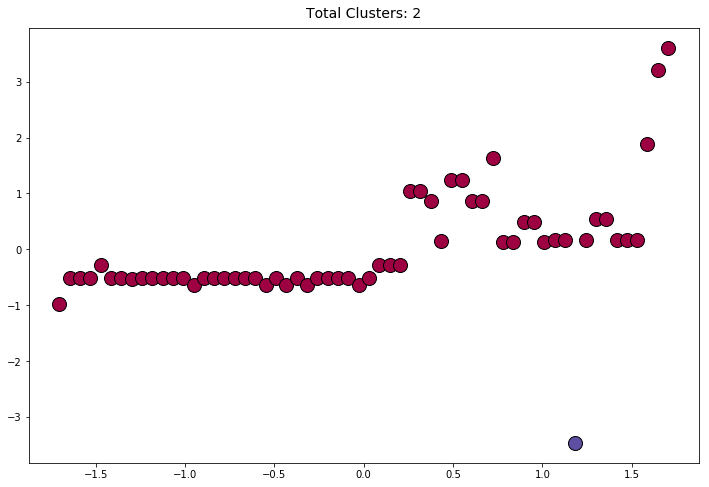

In [48]:
test_clusters(px, 1.5, 50, 300)

由于我们将eps的值由0.5改为了1.5，所以只会聚出两个分组：典型的票价和不正常的票价。

由于我们寻找的是错误的票价，因此希望它们等于所显示的最低价格。我们可以按照聚类来分组并检索最低的价格。

In [50]:
pf = pd.concat([ff, pd.DataFrame(db.labels_, columns=['cluster'])], axis=1)
pf

,index,fare,cluster
0,0,459.000000,0
1,1,489.573997,1
2,2,489.573997,1
3,3,489.573997,1
4,4,504.175905,1
5,5,489.573997,1
6,6,489.573997,1
7,7,488.203817,1
8,8,489.573997,1
9,9,489.573997,1


下面按照聚类来分组并显示分组中最低的价格和成员的数量。

In [51]:
rf = pf.groupby('cluster')['fare'].agg(['min','count']).sort_values('min', ascending=True)
rf

,min,count
cluster,,
0,459.000000,1
1,481.572951,33
2,530.579357,23
3,642.593999,1
4,727.705125,2


这里我们预计错误聚类将小于主聚类。我们对错误聚类的大小设置一个限制，要求它小于总数的10%。这个数字将根据不同聚类的数量和大小而变化。

In [52]:
rf.describe([.10,.25,.5,.75,.9])

,min,count
count,5.000000,5.000000
mean,568.290286,12.000000
std,113.820593,15.033296
min,459.000000,1.000000
10%,468.029180,1.000000
25%,481.572951,1.000000
50%,530.579357,2.000000
75%,642.593999,23.000000
90%,693.660675,29.000000
max,727.705125,33.000000


In [53]:
rf['count'].quantile(.10)

1.0

In [54]:
pd.Series([50,6,4]).quantile(.10)

4.4